In [2]:
#SVM+SIFT baseline model 
#Author: Shuo Jia
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import svm 
from sklearn.model_selection  import train_test_split 
from sklearn.metrics import accuracy_score  
import pickle  
from PIL import Image
import pandas as pd

In [5]:
df = pd.read_csv("data.csv")

In [6]:
img_path = df['path']
img_label = df['label']

In [7]:
#convert img_path type to string
img_path = np.array(img_path)

#convert img_label type to int
img_label = np.array(img_label)



In [8]:
# a function to extract the SIFT features
def extract_features(image_path):
    image = cv2.imread(image_path)
    #resize all images to 100*100
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray, None)
    image = cv2.drawKeypoints(gray, kp, image)
    kp,des = sift.compute(gray, kp)
    #des = des.flatten()
    return des

In [9]:
#extract features from all images
features = []
for image_path in img_path:
    des = extract_features(image_path)
    #des = des.flatten()
    #print(des.shape)
    features.append(des)


In [10]:
# padding the features
max_len = 0 
for feature in features:
    if feature.shape[0] > max_len:
        max_len = feature.shape[0]
#print(max_len)

#fill the features' first dimension to max_len
for i  in range(len(features)):
    if features[i].shape[0] < max_len:
        features[i] = np.pad(features[i], ((0, max_len - features[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    #print(features[i].shape)


In [11]:
#flatten the features
for i in range(len(features)):
    features[i] = features[i].flatten()
    #print(features[i].shape)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(features)
features = pca.transform(features)
features.shape

(2107, 1284)

In [13]:
#split the dataset into training and testing set, training set is 80% of the dataset
X_train, X_test, y_train, y_test = train_test_split(features, img_label, test_size=0.2, random_state=42)

#convert list to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

#convert list to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)



In [14]:
#gradesearch to find the best parameters
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'poly', 'rbf','sigmoid'), 'C':[0.1, 1, 10, 100, 1000],'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)



from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=clf,
                        X=X_train,
                        y=y_train,
                       cv=10,
                       n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

#clf.fit(X_train, y_train)


sorted(clf.cv_results_.keys())
# best parameters
clf.best_params_
# best score
clf.best_score_
# best accuracy
clf.best_estimator_.score(X_test, y_test)


0.504739336492891

In [15]:
#best parameters
clf.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

In [16]:

#save the model
pickle.dump(clf, open('model_ovo.pkl', 'wb'))

In [20]:
#predict the test set
y_pred = clf.predict(X_test)

#calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.504739336492891


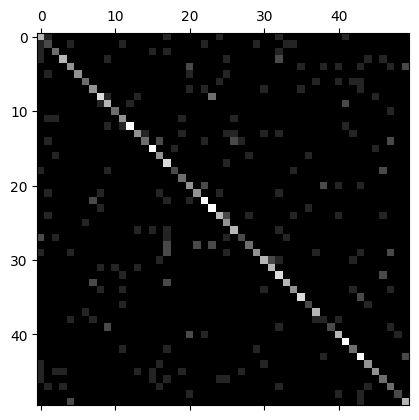

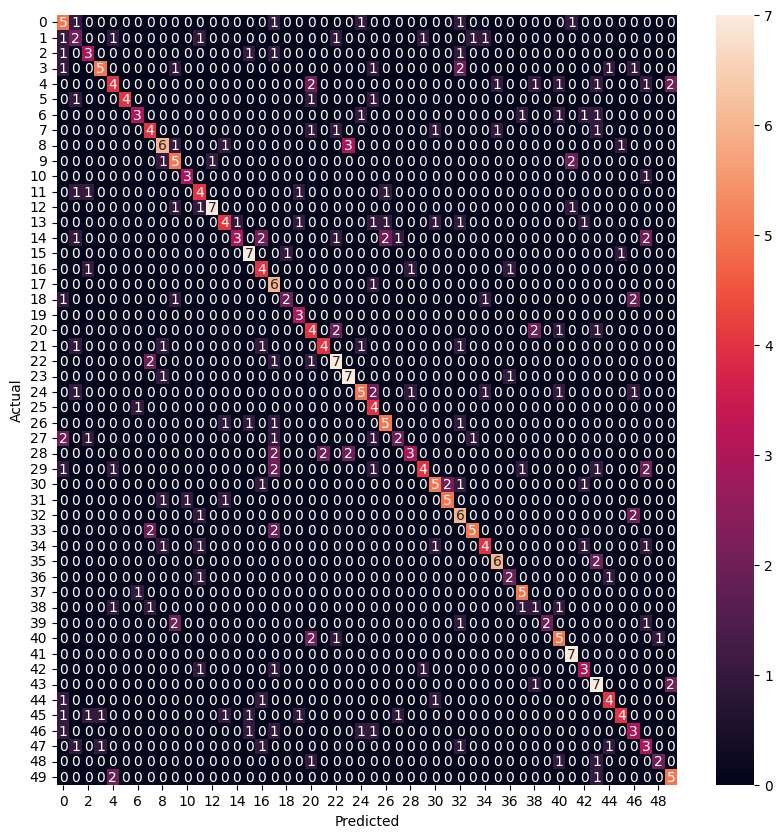

In [21]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
conf_mx = confusion_matrix(y_test, y_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
#save the confusion matrix
np.save('confusion_matrix.npy', conf_mx)


#classification report
from sklearn.metrics import classification_report
classification_report(y_test, y_pred)
#save the classification report
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred))



#plot the confusion matrix
import seaborn as sns
conf_mx = np.load('confusion_matrix.npy')
plt.figure(figsize=(10,10))
sns.heatmap(conf_mx, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#plot the classification report
import pandas as pd
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('classification_report.csv')



In [27]:
#true positive rate
TP = np.diag(conf_mx)
#false positive rate
FP = np.sum(conf_mx, axis=0) - TP
#false negative rate
FN = np.sum(conf_mx, axis=1) - TP
#true negative rate
TN = np.sum(conf_mx) - (FP + FN + TP)

#save the true positive rate as txt file
np.savetxt('TP.txt', TP, fmt='%d')
#save the false positive rate as txt file
np.savetxt('FP.txt', FP, fmt='%d')

#save the false negative rate as txt file
np.savetxt('FN.txt', FN, fmt='%d')

#save the true negative rate as txt file
np.savetxt('TN.txt', TN, fmt='%d')







